Jupyter Notebook for AI_Weeder by Nicolai Bledow


In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE


2024-09-05 14:37:02.973932: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 14:37:02.984494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 14:37:02.995625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 14:37:02.998942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 14:37:03.008697: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/nico/code/dorwein/ai_weeder/notebooks


In [3]:
# Change the working directory to the project's root
os.chdir('/home/nico/code/dorwein/ai_weeder')

# Confirm the change
print("New Working Directory:", os.getcwd())

New Working Directory: /home/nico/code/dorwein/ai_weeder


In [4]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/nico/code/dorwein/ai_weeder


In [5]:
# Absolute path to the directory containing the images
main_dir = '/home/nico/code/dorwein/ai_weeder/raw_data/nonsegmentedv2'

# Define image size and batch size
img_height, img_width = 81, 81
batch_size = 16

# Load dataset and split into training and validation sets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check class names
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Found 5196 files belonging to 12 classes.
Using 4157 files for training.
Found 5196 files belonging to 12 classes.


I0000 00:00:1725539825.144351  601239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-05 14:37:05.182324: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Using 1039 files for validation.
Class names: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [6]:
# Check some properties of the dataset
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

val_dataset

Images shape: (16, 81, 81, 3)
Labels shape: (16,)
Images shape: (16, 81, 81, 3)
Labels shape: (16,)


2024-09-05 14:37:05.628799: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-05 14:37:05.670372: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 81, 81, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
# Check a sample of labels to ensure they are integers
for images, labels in train_dataset.take(1):
    print(f"Sample labels: {labels.numpy()}")

Sample labels: [11  8 10  8 10  7  1  1  3  2 10  9  7  3 10  9]


In [8]:
# CIELUV

# Function to apply the CIELUV distance layer and handle shape mismatch
def apply_cieluv_distance(images):
    # Assuming images has shape (batch_size, height, width, channels)
    batch_size = tf.shape(images)[0]
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]

    # Create dummy CIELUV distance tensor with same batch size and specified dimensions
    cieluv_distance = tf.random.uniform((batch_size, height, width, 1))

    # Expand dimensions to match the number of channels
    cieluv_distance_expanded = tf.tile(cieluv_distance, [1, 1, 1, 3])

    # Concatenate along the channel axis
    return tf.concat([images, cieluv_distance_expanded], axis=-1)

# Apply CIELUV distance augmentation to the dataset
def add_cieluv_distance_to_dataset(dataset):
    return dataset.map(lambda x, y: (apply_cieluv_distance(x), y))

In [9]:
# Apply CIELUV distance augmentation to the datasets
train_dataset_with_distance = add_cieluv_distance_to_dataset(train_dataset)
val_dataset_with_distance = add_cieluv_distance_to_dataset(val_dataset)

# Check some properties of the dataset
for images, labels in train_dataset_with_distance.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (16, 81, 81, 6)
Labels shape: (16,)


2024-09-05 14:37:05.937683: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


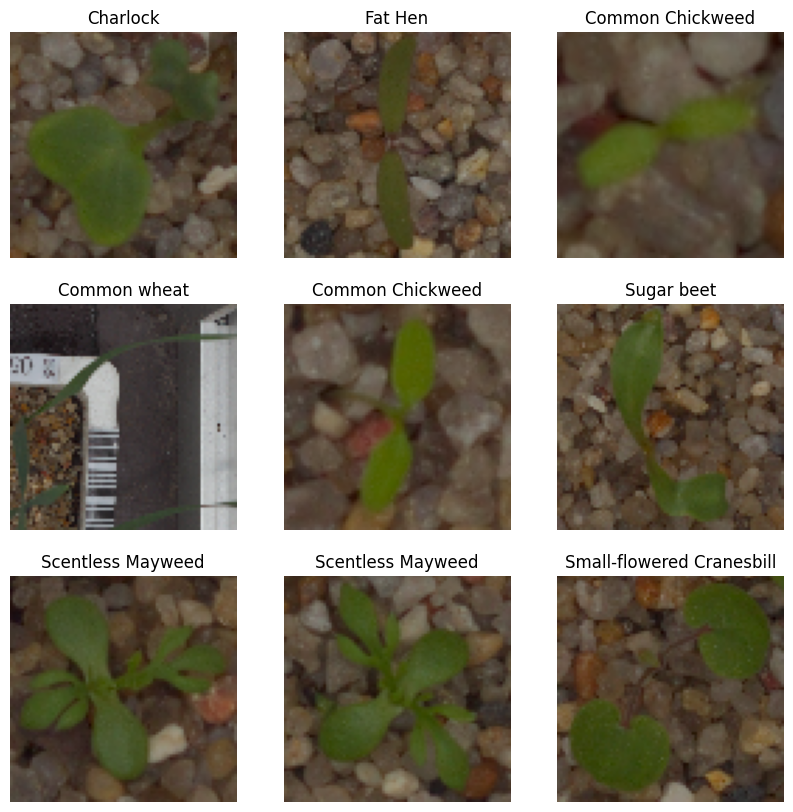

In [10]:
# Function to display images with CIELUV distance channels
def plot_images_from_dataset(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            image_rgb = images[i, :, :, :3]  # Slice the RGB channels
            plt.imshow(image_rgb.numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()

# Plot examples from the training dataset with CIELUV distance
plot_images_from_dataset(train_dataset_with_distance, class_names)

In [11]:
def apply_cieluv_distance(images):
    cieluv_distance = tf.random.uniform((tf.shape(images)[0], 81, 81, 1))
    cieluv_distance_expanded = tf.tile(cieluv_distance, [1, 1, 1, 3])
    return images + cieluv_distance_expanded

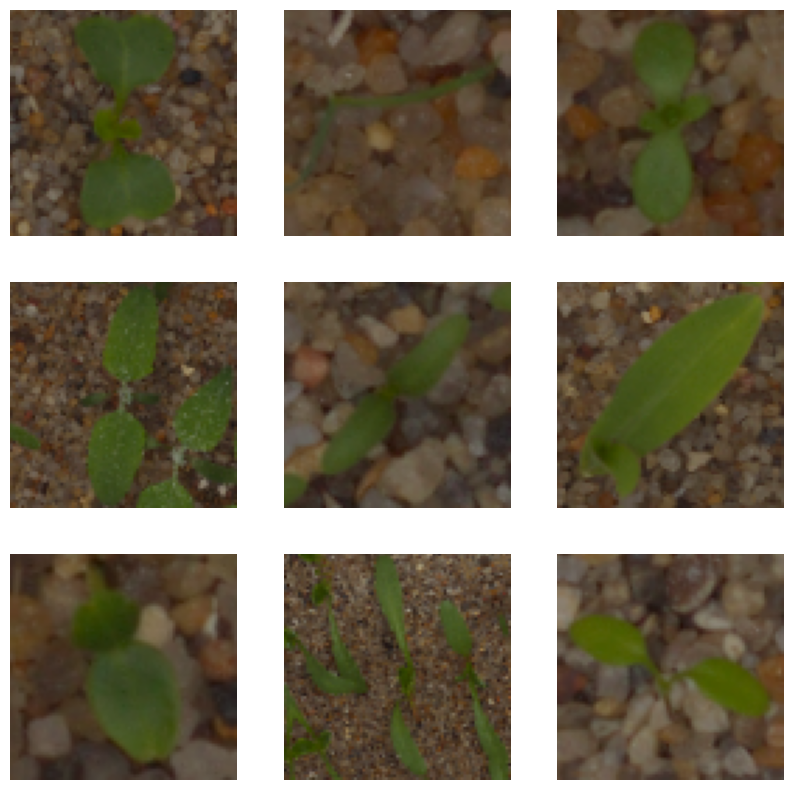

In [12]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
])

# Apply augmentation and plot
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [14]:
# Check some properties of the dataset
for images, labels in train_dataset_with_distance.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

for images, labels in val_dataset_with_distance.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")


Images shape: (16, 81, 81, 6)
Labels shape: (16,)
Images shape: (16, 81, 81, 6)
Labels shape: (16,)


2024-09-05 14:37:07.003485: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:

# tf.keras.models

# Define the CNN model with more kernels
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Input layer and first convolutional
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.2))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.2))

    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.2))

    # Fourth convolutional block
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.3))

    # Flatten the 3D feature maps to 1D feature vectors
    model.add(layers.Flatten())
    # Fully connected layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer with softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Set input shape and number of classes
input_shape = (81, 81, 6)
num_classes = 12

# Create the CNN model
cnn_model = create_cnn_model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model architecture
cnn_model.summary()

/home/nico/.pyenv/versions/3.10.6/envs/ai_weeder/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 81, 81, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,210,156 (4.62 MB)

 Trainable params: 1,210,156 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Number of epochs
epochs = 60

# Train the CNN model
history = cnn_model.fit(
    train_dataset_with_distance,
    validation_data=val_dataset_with_distance,
    epochs=epochs,
    verbose=1,
)


Epoch 1/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.1202 - loss: 6.1626 - val_accuracy: 0.2512 - val_loss: 2.2392
Epoch 2/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2698 - loss: 2.1103 - val_accuracy: 0.5053 - val_loss: 1.6191
Epoch 3/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.4181 - loss: 1.7179 - val_accuracy: 0.5621 - val_loss: 1.3424
Epoch 4/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5406 - loss: 1.4183 - val_accuracy: 0.6843 - val_loss: 1.1104
Epoch 5/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5763 - loss: 1.2771 - val_accuracy: 0.6497 - val_loss: 1.1333
Epoch 6/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6137 - loss: 1.1796 - val_accuracy: 0.6458 - val_loss: 1.0822
Epoch 7/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.6450 - loss: 1.0834 - val_accuracy: 0.7411 - val_loss: 0.8993
Epoch 8/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6899 - loss: 0.9433 - 

In [18]:
# Evaluate the model and calculate F1 Score
evaluate = cnn_model.evaluate(val_dataset_with_distance)
evaluate

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8607 - loss: 0.4281


[0.4580666124820709, 0.8604427576065063]

In [ ]:
# Evaluate the model and calculate F1 Score
# precision = cnn_model.evaluate(val_dataset)[0]  # only makes sense if we can ouput precision and recall
# recall = cnn_model.evaluate(val_dataset)[1]     # only makes sense if we can ouput precision and recall

# f1_score = 2 * (precision * recall) / (precision + recall)
# print(f"F1 Score: {f1_score}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8612 - loss: 0.4163
Validation Loss: 0.45879969000816345
Validation Accuracy: 0.8604427576065063


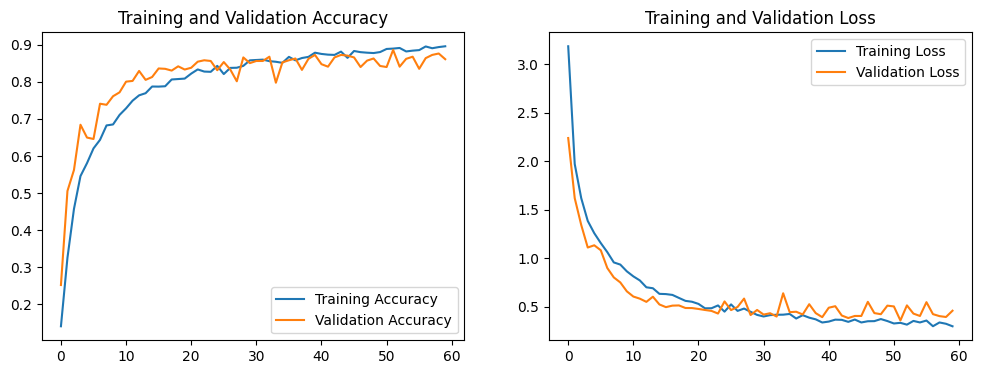

In [19]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = cnn_model.evaluate(val_dataset_with_distance)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

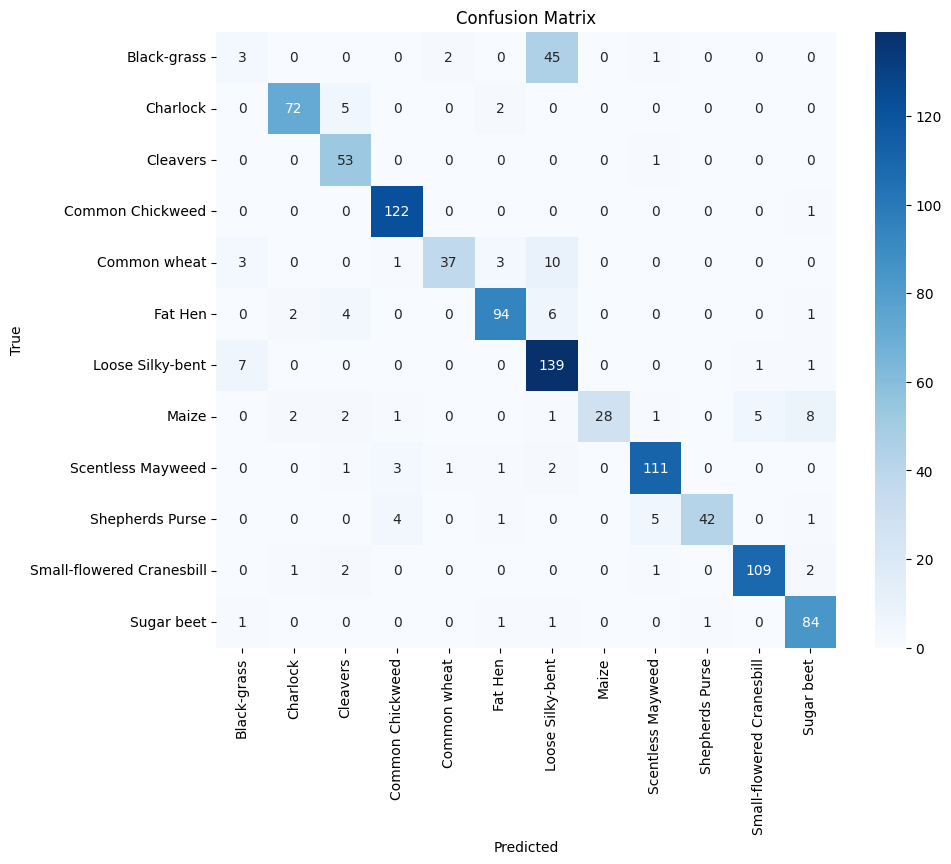

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

# Assuming 'cnn_model' is your trained model and 'val_dataset' is the validation dataset
# Get the true labels and predicted labels from the validation set
true_labels = []
predicted_labels = []

# Loop over the validation set to collect true labels and predictions
for images, labels in val_dataset_with_distance:
    # Get model predictions
    preds = cnn_model.predict(images)
    # Convert predictions from probabilities to class indices
    predicted_class_indices = np.argmax(preds, axis=1)

    true_labels.extend(labels.numpy())  # Append true labels
    predicted_labels.extend(predicted_class_indices)  # Append predicted labels

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score

# Assuming true_labels and predicted_labels are already calculated as in the previous step

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average=None)  # 'average=None' gives precision per class
recall = recall_score(true_labels, predicted_labels, average=None)        # 'average=None' gives recall per class

# Display precision and recall for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print('-' * 30)

# If you want to calculate the macro or weighted averages for overall precision and recall:
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')

weighted_precision = precision_score(true_labels, predicted_labels, average='weighted')
weighted_recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")


Class: Black-grass
Precision: 0.21428571428571427
Recall: 0.058823529411764705
------------------------------
Class: Charlock
Precision: 0.935064935064935
Recall: 0.9113924050632911
------------------------------
Class: Cleavers
Precision: 0.7910447761194029
Recall: 0.9814814814814815
------------------------------
Class: Common Chickweed
Precision: 0.9312977099236641
Recall: 0.991869918699187
------------------------------
Class: Common wheat
Precision: 0.925
Recall: 0.6851851851851852
------------------------------
Class: Fat Hen
Precision: 0.9215686274509803
Recall: 0.8785046728971962
------------------------------
Class: Loose Silky-bent
Precision: 0.6813725490196079
Recall: 0.9391891891891891
------------------------------
Class: Maize
Precision: 1.0
Recall: 0.5833333333333334
------------------------------
Class: Scentless Mayweed
Precision: 0.925
Recall: 0.9327731092436975
------------------------------
Class: Shepherds Purse
Precision: 0.9767441860465116
Recall: 0.7924528301886

In [23]:
# Assuming macro_precision, macro_recall, weighted_precision, weighted_recall are already calculated

# Calculate Macro F1 Score
macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)

# Calculate Weighted F1 Score
weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)

print(f"Macro F1 Score: {macro_f1}")
print(f"Weighted F1 Score: {weighted_f1}")

Macro F1 Score: 0.8230635597116566
Weighted F1 Score: 0.856447721405579


In [24]:
from sklearn.metrics import f1_score

# Assuming true_labels and predicted_labels are already calculated

# Calculate the F1 score (micro-averaged)
micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

# Calculate the F1 score (weighted, macro, or other averaging methods if needed)
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Micro-Averaged F1 Score: {micro_f1}")
print(f"Weighted F1 Score: {weighted_f1}")
print(f"Macro F1 Score: {macro_f1}")

Micro-Averaged F1 Score: 0.8604427333974976
Weighted F1 Score: 0.8464896027965486
Macro F1 Score: 0.8100283489150346


In [25]:
# Path to the directory containing the test images
test_dir = '/home/nico/code/dorwein/ai_weeder/raw_data/test'

# Define image size and batch size
img_height, img_width = 81, 81  # Make sure these match your model's input size
batch_size_test = 1

# Load test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size_test,
    shuffle=False  # Don't shuffle so predictions and labels match up
)

# Check class names if needed
class_names = test_dataset.class_names
print(f"Class names: {class_names}")

Found 343 files belonging to 12 classes.
Class names: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [26]:
# Make predictions on the test dataset
test_predictions = cnn_model.predict(test_dataset)

# Convert the probabilities/logits to class labels
test_pred_labels = np.argmax(test_predictions, axis=1)

# Get the true labels
test_true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Optionally, print the first few predictions and true labels
print("Predicted labels:", test_pred_labels[:100])
print("True labels:", test_true_labels[:100])

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 6, but received input with shape (1, 81, 81, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 81, 81, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(test_true_labels, test_pred_labels, target_names=class_names)
print(report)